In [16]:
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os

import keras.utils

from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, Lambda, MaxPooling2D, ZeroPadding2D
from keras.models import Input, Model
from keras.optimizers import SGD, RMSprop, Adam
from keras.regularizers import l2

In [2]:
Nkeypoints = 15
W = 96
H = 96

## Keypoint Generator Class

In [6]:
class KeypointGenerator(keras.utils.Sequence):

    def __init__(self, directory, idxs, img_dict, labels_dict,
                 target_size=(96,96), batch_size=32, augment=True,
                 transform_dict = None, shuffle=True):

        self.directory = directory
        self.idxs = idxs
        self.img_dict = img_dict
        self.labels_dict = labels_dict
        self.transform_dict = transform_dict
        self.target_size = target_size
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    # shuffle indices at the end of each epoch
    def on_epoch_end(self):
        if self.shuffle is True:
            np.random.shuffle(self.idxs)

    # return number of batches per epoch
    def __len__(self):

        if self.augment is True:
            multiplier = 5
        else:
            multiplier = 1

        return int(np.floor(len(self.idxs) * multiplier / self.batch_size))

    # check if transformed point is located within image boundaries
    def _checkBoundaries(self, p):

        # x dimension
        if p[0] < 0:
            px = 0
        elif p[0] > self.target_size[0]:
            px = self.target_size[0]
        else:
            px = p[0]

        # y dimension
        if p[1] < 0:
            py = 0
        elif p[1] > self.target_size[1]:
            py = self.target_size[1]
        else:
            py = p[1]

        return (int(px), int(py))

    # apply shifts, rotations, scaling and flips to original image and keypoints
    def _transform_image(self, img, keypoints):

        aug_keypoints = []

        c = (img.shape[0] // 2, img.shape[1] // 2)

        if self.transform_dict['Flip']:
            flip = random.choice([True, False])
            if flip:
                img = cv.flip(img, flipCode=1)

        if self.transform_dict['Rotate']:

            if self.transform_dict['Scale']:
                s = random.uniform(0.7, 1.0)
            else:
                s = 1.0

            r = random.randint(-10, 10)
            M_rot = cv.getRotationMatrix2D(center=(img.shape[0] // 2, img.shape[1] // 2), angle=r, scale=s)
            img = cv.warpAffine(img, M_rot, (img.shape[0], img.shape[1]), borderMode=cv.BORDER_CONSTANT, borderValue=1)

        if self.transform_dict['Shift']:
            tx = random.randint(-20, 20)
            ty = random.randint(-20, 20)
            M_shift = np.array([[1, 0, tx], [0, 1, ty]], dtype=np.float32)
            img = cv.warpAffine(img, M_shift, (img.shape[0], img.shape[1]),
                                borderMode=cv.BORDER_CONSTANT, borderValue=1)

        # transform keypoints
        c = (img.shape[0] // 2, img.shape[1] // 2)

        for i in range(0, len(keypoints) - 1, 2):

            px = keypoints[i]
            py = keypoints[i+1]
            p = np.array([px, py, 1], dtype=int)

            # apply flip
            if self.transform_dict['Flip'] and flip:
                p[0] = c[0] - (p[0] - c[0])

            # apply rotation
            if self.transform_dict['Rotate']:
                p = np.dot(M_rot, p)

            # apply horizontal / vertical shifts
            if self.transform_dict['Shift']:
                p[0] += tx
                p[1] += ty

            p = self._checkBoundaries(p)

            aug_keypoints.append(p[0])
            aug_keypoints.append(p[1])

        return img, aug_keypoints

    # load image from disk
    def _load_image(self, fn):

        img = cv.imread(filename=os.path.join(self.directory, fn))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        img = np.float32(img) / 255

        return img

    # generate batches of scaled images and bounding boxes
    def _data_generation(self, idxs):

        x = []
        y = []

        for idx in idxs:
            img = self._load_image(self.img_dict[idx])
            keypoints = self.labels_dict[idx]

            if self.augment is True and self.transform_dict:
                img, keypoints = self._transform_image(img, keypoints)

            img = np.reshape(img, (96, 96, 1))
            x.append(img)
            y.append(keypoints)

        return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32) / img.shape[0]

    # return indices for train batches
    def _get_train_idxs(self, idx):

        # number of batches in original train set
        N = int(np.floor(len(self.idxs) / self.batch_size))

        # idx exceeds original image indices
        if idx > N:

            # reset start idx
            if idx % N == 0:
                reset_idx = 0 #((idx - 1) % N) + 1
            else:
                reset_idx = idx % N - 1

            start = reset_idx * self.batch_size

            # end idx
            if (reset_idx + 1) * self.batch_size > len(self.idxs):
                end = len(self.idxs)
            else:
                end = (reset_idx + 1) * self.batch_size

        # idx is within in original train set
        else:
            start = idx * self.batch_size
            end = (idx + 1) * self.batch_size

        return start, end

    # return indices for val batches
    def _get_val_idxs(self, idx):

        if (idx + 1) * self.batch_size > len(self.idxs):
            end = len(self.idxs)
        else:
            end = (idx + 1) * self.batch_size

        return idx * self.batch_size, end

    # return batch of image data and labels
    def __getitem__(self, idx):

        if self.augment is True:
            start_batch_idx, end_batch_idx = self._get_train_idxs(idx)
        else:
            start_batch_idx, end_batch_idx = self._get_val_idxs(idx)

        idxs = self.idxs[start_batch_idx:end_batch_idx]
        batch_x, batch_y = self._data_generation(idxs)

        return batch_x, batch_y

## Visualize Keypoints

In [9]:
def show_keypoints(batch_imgs, batch_labels, nrows, ncols, preds=None):

    def draw_keypoints(img, keypoints, col):
        
        for i in range(0, len(keypoints)-1, 2):
            # print(i)
            kpx = int(keypoints[i]*img.shape[0])
            kpy = int(keypoints[i+1]*img.shape[1])
            img = cv.circle(img, center=(kpx,kpy), radius=2, color=col, thickness=2)

        return img

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    r = -1

    for i in range(len(batch_imgs)):

        img = batch_imgs[i]
        img = np.reshape(img, newshape=(96,96))
        img = np.stack([img,img,img], axis=-1)

        c = i % ncols

        if i % ncols == 0:
            r += 1

        # draw ground-truth keypoints on image
        img = draw_keypoints(img, batch_labels[i], col=(0,0,255))

        # draw predicted keypoints on image
        if preds is not None:
            img = draw_keypoints(img, preds[i], col=(255,0,0))

        axes[r, c].imshow(img)

    plt.show()

## Load Training Data

In [4]:
data_dir = "/storage/data/facial-keypoints"
train_dir = "train"
train_csv = "training.csv"
test_dir = "test"
test_csv = "test.csv"

df_train = pd.read_csv(os.path.join(data_dir, train_csv))
df_test = pd.read_csv(os.path.join(data_dir, test_csv))

n_train = df_train['Image'].size
n_test = df_test['Image'].size

df_kp = df_train.iloc[:,0:30]

idxs = []

img_dict = {}
kp_dict = {}

for i in range(n_train):
    
    # only select data from csv that has 15 keypoint labels
    if True in df_train.iloc[i, 0:30].isna().values:
        continue
    else:
        idxs.append(i)
        img_dict[i] = "train"+str(i)+".png"
        kp = df_kp.iloc[i].values.tolist()
        kp_dict[i] = kp

## Split Data into Train / Val Sets


# of Training Images: 1926
# of Val Images: 214

# of training batches= 300
# of validation batches= 6
(32, 96, 96, 1)
(32, 30)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

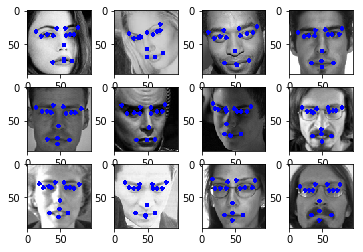

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 96, 96, 1)
(32, 30)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


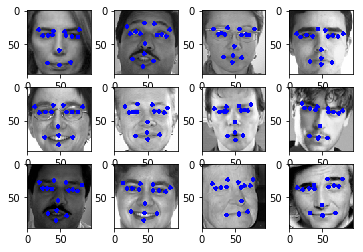

In [10]:
random.shuffle(idxs)
cutoff_idx = int(0.9*len(idxs))
train_idxs = idxs[0:cutoff_idx]
val_idxs = idxs[cutoff_idx:len(idxs)]

print("\n# of Training Images: {}".format(len(train_idxs)))
print("# of Val Images: {}".format(len(val_idxs)))

transform_dict = {"Flip": False, "Shift": False, "Scale": False, "Rotate": False}

train_gen = KeypointGenerator(os.path.join(data_dir, train_dir),
                              train_idxs,
                              img_dict,
                              kp_dict,
                              transform_dict=transform_dict,
                              augment=True)

val_gen = KeypointGenerator(os.path.join(data_dir, train_dir),
                            val_idxs,
                            img_dict,
                            kp_dict,
                            augment=False)

print("\n# of training batches= %d" % len(train_gen))
print("# of validation batches= %d" % len(val_gen))

train_imgs, train_keypoints = train_gen[0]
print(train_imgs.shape)
print(train_keypoints.shape)
show_keypoints(train_imgs[0:12], train_keypoints[0:12], nrows=3, ncols=4)

val_imgs, val_keypoints = val_gen[0]
print(val_imgs.shape)
print(val_keypoints.shape)
show_keypoints(val_imgs[0:12], val_keypoints[0:12], nrows=3, ncols=4)

## Architecture

### VGG-16

In [14]:
def VGG(input_shape):

    def conv_block(x, n_filters, block_num):
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same',
                   kernel_regularizer=l2(5e-4), name="Conv" + str(block_num))(x)
        x = BatchNormalization(name="bN" + str(block_num))(x)
        x = Activation("relu", name="relu"+str(block_num))(x)

        return x

    input = Input(input_shape, name="Input")

    # Layers 1-2
    x = conv_block(input, n_filters=64, block_num=1)
    x = conv_block(x, n_filters=64, block_num=2)
    x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid', name='pool1')(x)

    # Layers 3-4
    x = conv_block(x, n_filters=128, block_num=3)
    x = conv_block(x, n_filters=128, block_num=4)
    x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid', name='pool2')(x)

    # Layers 5-7
    x = conv_block(x, n_filters=256, block_num=5)
    x = conv_block(x, n_filters=256, block_num=6)
    x = conv_block(x, n_filters=256, block_num=7)
    x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid', name='pool3')(x)

    # Layers 8-10
    x = conv_block(x, n_filters=512, block_num=8)
    x = conv_block(x, n_filters=512, block_num=9)
    x = conv_block(x, n_filters=512, block_num=10)
    x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid', name='pool4')(x)

    # Layers 11-13
    x = conv_block(x, n_filters=512, block_num=11)
    x = conv_block(x, n_filters=512, block_num=12)
    x = conv_block(x, n_filters=512, block_num=13)
    x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid', name='pool5')(x)

    # Layers 14-16
    x = Flatten()(x)
    x = Dropout(rate=0.5)(x)
    # x = Dense(units=4096, activation='relu', kernel_regularizer=l2(5e-4), name="Dense1")(x)
    # x = Dropout(rate=0.5)(x)
    x = Dense(units=512, activation='relu', kernel_regularizer=l2(5e-4), name="Dense1")(x)

    # output
    output = Dense(units=2*Nkeypoints, activation='linear', kernel_regularizer=l2(5e-4), name="output")(x)

    model = Model(inputs=input, outputs=output, name="VGG")

    return model


vgg16 = VGG((H,W,1))
print("{}".format(vgg16.summary()))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 96, 96, 1)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 96, 96, 64)        640       
_________________________________________________________________
bN1 (BatchNormalization)     (None, 96, 96, 64)        256       
_________________________________________________________________
relu1 (Activation)           (None, 96, 96, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 96, 96, 64)        36928     
_________________________________________________________________
bN2 (BatchNormalization)     (None, 96, 96, 64)        256       
_________________________________________________________________
relu2 (Activation)           (None, 96, 96, 64)        0         
__________

### ResNet-50

In [17]:
# checks if block input and output have the same dimensions
def check_shape(x):
    dims_input = x[0].get_shape().as_list()
    dims_output = x[1].get_shape().as_list()

    # case 1: resolution is the same but depth is different
    # use 1x1 convolution to extend input tensor depth
    if dims_input[3] != dims_output[3] and dims_input[1] == dims_output[1]:
        x[0] = Conv2D(filters=dims_output[3], kernel_size=(1, 1), strides=1, kernel_regularizer=l2(1e-4),
                      kernel_initializer='he_normal')(x[0])
        x[0] = BatchNormalization()(x[0])

    # case 2: resolution and depth varies
    # use 1x1 convolution to extend input tensor depth and stride 2 to halve its resolution
    elif dims_input[1] != dims_output[1] and dims_input[3] != dims_output[3]:
        x[0] = Conv2D(filters=dims_output[3], kernel_size=(1, 1), strides=2, kernel_regularizer=l2(1e-4),
                      kernel_initializer='he_normal')(x[0])
        x[0] = BatchNormalization()(x[0])

    return x[0]


# adds block input to block output
def res_block(block_input, block_name, n_filt1, n_filt2, n_filt3, padding_type='valid', s=2):
    # 1x1 convolution reduction
    x = Conv2D(filters=n_filt1, kernel_size=(1, 1), strides=s, padding=padding_type, kernel_regularizer=l2(1e-4),
               kernel_initializer='he_normal', name=block_name + "_conv1")(block_input)
    x = BatchNormalization(name=block_name + "_BN1")(x)
    x = Activation('relu', name=block_name + "_actv1")(x)
    # print(x)

    # 3x3 convolution
    x = Conv2D(filters=n_filt2, kernel_size=(3, 3), strides=1, padding='same', kernel_regularizer=l2(1e-4),
               kernel_initializer='he_normal', name=block_name + "_conv2")(x)
    x = BatchNormalization(name=block_name + "_BN2")(x)
    x = Activation('relu', name=block_name + "_actv2")(x)

    # 1x1 convolution expansion
    x = Conv2D(filters=n_filt3, kernel_size=(1, 1), strides=1, padding='same', kernel_regularizer=l2(1e-4),
               kernel_initializer='he_normal', name=block_name + "_conv3")(x)
    x = BatchNormalization(name=block_name + "_BN3")(x)

    # check input and output dimensions
    block_input = Lambda(function=check_shape, name=block_name + "_lambda")([block_input, x])

    # add residual
    block_output = Add(name=block_name + "_add")([block_input, x])
    block_output = Activation('relu', name=block_name + "_actv3")(block_output)

    return block_output

def ResNet(input_shape):
    input = Input(input_shape, name='Input')

    # block 1
    x = ZeroPadding2D(padding=(3, 3), name="block1_padding1")(input)
    x = Conv2D(filters=64, kernel_size=(7, 7), padding='valid', strides=2, kernel_regularizer=l2(1e-4),
               kernel_initializer='he_normal', name="block1_conv1")(x)
    x = BatchNormalization(name="block1_BN1")(x)
    x = Activation('relu', name="block1_actv1")(x)

    # block 2
    x = MaxPooling2D(pool_size=(3, 3), strides=2, name="block2_max_pool1")(x)
    x = res_block(x, "block2a", n_filt1=64, n_filt2=64, n_filt3=256, padding_type='same', s=1)
    x = res_block(x, "block2b", n_filt1=64, n_filt2=64, n_filt3=256, padding_type='same', s=1)
    x = res_block(x, "block2c", n_filt1=64, n_filt2=64, n_filt3=256, padding_type='same', s=1)

    # block 3
    x = res_block(x, "block3a", n_filt1=128, n_filt2=128, n_filt3=512, padding_type='valid', s=2)
    x = res_block(x, "block3b", n_filt1=128, n_filt2=128, n_filt3=512, padding_type='same', s=1)
    x = res_block(x, "block3c", n_filt1=128, n_filt2=128, n_filt3=512, padding_type='same', s=1)
    x = res_block(x, "block3d", n_filt1=128, n_filt2=128, n_filt3=512, padding_type='same', s=1)

    # block 4
    x = res_block(x, "block4a", n_filt1=256, n_filt2=256, n_filt3=1024, padding_type='valid', s=2)
    x = res_block(x, "block4b", n_filt1=256, n_filt2=256, n_filt3=1024, padding_type='same', s=1)
    x = res_block(x, "block4c", n_filt1=256, n_filt2=256, n_filt3=1024, padding_type='same', s=1)
    x = res_block(x, "block4d", n_filt1=256, n_filt2=256, n_filt3=1024, padding_type='same', s=1)
    x = res_block(x, "block4e", n_filt1=256, n_filt2=256, n_filt3=1024, padding_type='same', s=1)
    x = res_block(x, "block4f", n_filt1=256, n_filt2=256, n_filt3=1024, padding_type='same', s=1)

    # block 5
    x = res_block(x, "block5a", n_filt1=512, n_filt2=512, n_filt3=2048, padding_type='valid', s=2)
    x = res_block(x, "block5b", n_filt1=512, n_filt2=512, n_filt3=2048, padding_type='same', s=1)
    x = res_block(x, "block5c", n_filt1=512, n_filt2=512, n_filt3=2048, padding_type='same', s=1)

    # Global pooling
    x = GlobalAveragePooling2D(name='global_pooling')(x)

    # output
    output = Dense(units=2*Nkeypoints, activation='linear', kernel_regularizer=l2(1e-4), kernel_initializer='he_normal',
                   name='output')(x)

    return Model(input, output, name='ResNet50')

resnet50 = ResNet((H,W,1))
print("{}".format(resnet50.summary()))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
block1_padding1 (ZeroPadding2D) (None, 102, 102, 1)  0           Input[0][0]                      
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 48, 48, 64)   3200        block1_padding1[0][0]            
__________________________________________________________________________________________________
block1_BN1 (BatchNormalization) (None, 48, 48, 64)   256         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_act

## Training

In [20]:
def create_callbacks(wts_fn, csv_fn, patience=5, enable_save_wts = True):

    cbks = []

    # early stopping
    early_stopper = EarlyStopping(monitor='val_loss', patience=patience)
    cbks.append(early_stopper)

    # model checkpoint
    if enable_save_wts is True:
        model_chpt = ModelCheckpoint(filepath=wts_fn,
                                     monitor='val_loss',
                                     verbose=1,
                                     save_weights_only=True,
                                     save_best_only=True,
                                     period=patience)

        cbks.append(model_chpt)
    
    # csv logger
    csv_logger = CSVLogger(csv_fn)
    cbks.append(csv_logger)

    return cbks


def trainModel(model, model_name, n_epochs, lr, load_saved_wts = False):

    wts_fn = model_name + ".h5"
    csv_fn = model_name + ".csv"
    cbks = create_callbacks(wts_fn, csv_fn)
    
    optim = Adam(lr)
    
    if load_saved_wts is True:
        model.load_weights(wts_fn)

    model.compile(loss='mean_squared_error', optimizer=optim, metrics=None)
    model.fit_generator(generator=train_gen,
                        validation_data=val_gen,
                        epochs=n_epochs,
                        callbacks=cbks)

    return model

### Train Models

In [62]:
vgg16 = trainModel(vgg16, "vgg_lr=1e-2", n_epochs=20, lr=1e-3, load_saved_wts=True)

Epoch 1/20
300/300 [==============================] - 85s 282ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2/20
300/300 [==============================] - 76s 254ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 3/20
300/300 [==============================] - 76s 254ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/20
300/300 [==============================] - 76s 254ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/20
300/300 [==============================] - 76s 255ms/step - loss: 0.0011 - val_loss: 0.0012

Epoch 00005: val_loss improved from inf to 0.00116, saving model to vgg_lr=1e-2.h5
Epoch 6/20
300/300 [==============================] - 76s 254ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/20
300/300 [==============================] - 76s 255ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/20
300/300 [==============================] - 76s 254ms/step - loss: 0.0012 - val_loss: 0.0012


In [50]:
resnet50 = trainModel(resnet50, "resnet_lr=1e-3", n_epochs=20, lr=1e-4, load_saved_wts=True)

Epoch 1/20
300/300 [==============================] - 90s 299ms/step - loss: 0.0113 - val_loss: 0.0099
Epoch 2/20
300/300 [==============================] - 72s 241ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 3/20
300/300 [==============================] - 72s 241ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 4/20
300/300 [==============================] - 72s 241ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 5/20
300/300 [==============================] - 72s 241ms/step - loss: 0.0060 - val_loss: 0.0059

Epoch 00005: val_loss improved from inf to 0.00590, saving model to resnet_lr=1e-3.h5
Epoch 6/20
300/300 [==============================] - 72s 241ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 7/20
300/300 [==============================] - 72s 241ms/step - loss: 0.0048 - val_loss: 0.0065
Epoch 8/20
300/300 [==============================] - 72s 241ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 9/20
300/300 [==============================] - 72s 241ms/step - loss: 0.0038 - val

## Evaluation on Validation Set

In [22]:
def calc_RMS_ERROR(model, gen, img_size = 96):
    
    counter = 0
    total_error = 0

    for i in range(len(gen)+1):
        
        imgs, keypoints = gen[i]
        predictions = model.predict_on_batch(x=imgs)
    
        batch_error = np.sqrt(np.sum(np.power(keypoints*img_size-predictions*img_size, 2))) 
        total_error+=batch_error
        counter+=1
        
        print("Batch {} RMS Error = {}".format(counter, batch_error/keypoints.shape[0]))
        
    return total_error / len(val_idxs)
    
    

### VGG-16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


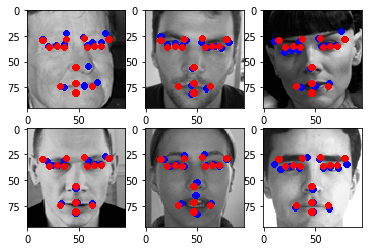

In [63]:
imgs, keypoints = val_gen[0]
vgg16.load_weights("vgg_lr=1e-3.h5")
val_preds = vgg16.predict_on_batch(x=imgs)
show_keypoints(imgs[0:6], keypoints, nrows=2, ncols=3, preds=val_preds)

In [64]:
val_rms_error = calc_RMS_ERROR(vgg16, val_gen)
print("Validation RMS Error = {}".format(val_rms_error))

Batch 1 RMS Error = 3.304408073425293
Batch 2 RMS Error = 2.839327812194824
Batch 3 RMS Error = 3.10670804977417
Batch 4 RMS Error = 3.595118761062622
Batch 5 RMS Error = 3.2536237239837646
Batch 6 RMS Error = 3.2415475845336914
Batch 7 RMS Error = 3.2431279962713067
Validation RMS Error = 3.225478056435273


### ResNet-50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


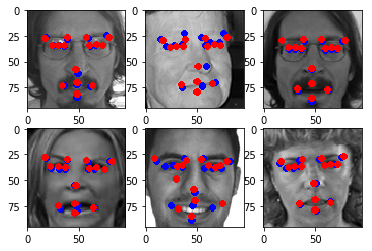

In [51]:
imgs, keypoints = val_gen[0]
resnet50.load_weights("resnet_lr=1e-4.h5")
val_preds = resnet50.predict_on_batch(x=imgs)
show_keypoints(imgs[0:6], keypoints, nrows=2, ncols=3, preds=val_preds)

In [52]:
val_rms_error = calc_RMS_ERROR(resnet50, val_gen)
print("Validation RMS Error = {}".format(val_rms_error))

Batch 1 RMS Error = 3.627135992050171
Batch 2 RMS Error = 3.675764560699463
Batch 3 RMS Error = 2.8126561641693115
Batch 4 RMS Error = 3.1448776721954346
Batch 5 RMS Error = 3.4557807445526123
Batch 6 RMS Error = 2.5772786140441895
Batch 7 RMS Error = 4.308509133078835
Validation RMS Error = 3.327939256329403


## Test Set Predictions

In [56]:
test_idxs = np.arange(0,1782)
random.shuffle(test_idxs)

Ntest = 32
test_imgs = []
for i in range(Ntest):
    fn=  "test"+str(test_idxs[i])+".png"
    
    img = cv.imread(os.path.join(data_dir, test_dir, fn))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    img = np.float32(img) / 255
    img = np.reshape(img, newshape=(96,96,1))
                    
    test_imgs.append(img)

test_imgs = np.array(test_imgs, dtype=np.float32)

In [65]:
vgg_preds = vgg16.predict_on_batch(x=test_imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


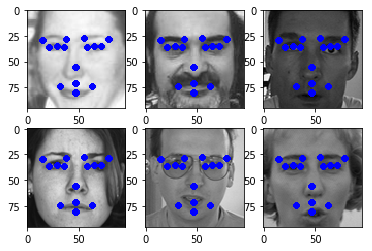

In [72]:
show_keypoints(test_imgs[0:6], vgg_preds, nrows=2, ncols=3, preds=None)

In [59]:
resnet_preds = resnet50.predict_on_batch(x=test_imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


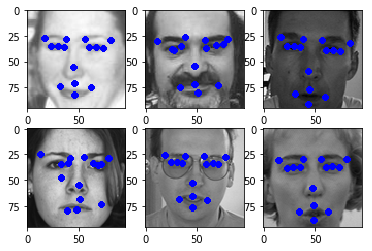

In [74]:
show_keypoints(test_imgs[0:6], resnet_preds[0:6], nrows=2, ncols=3)

### VGG-16 vs. ResNet50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


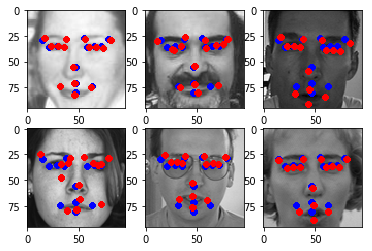

In [70]:
show_keypoints(test_imgs[0:6], vgg_preds, nrows=2, ncols=3, preds=resnet_preds[0:6])